# Topic Modeling with Bigrams
Update: 27.04.2021<br>
Mai Vu

In [3]:
#Basic libraries
import random
import time
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from collections import defaultdict

import warnings
warnings.filterwarnings("ignore", category = DeprecationWarning)

#Libraries for lemmatization
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

#Lirary to check the language in text
from langdetect import detect

#Libraries for topic modeling
import gensim
from gensim import corpora
import pprint
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel

#For plotting
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# Init steps

In [4]:
#Read the data
eng_data = pd.read_csv('eng_abstracts.csv')

In [5]:
#Create eng_stopwords set and lemmatizer from NLTK library
eng_stopwords = set(stopwords.words('english')).union(gensim.parsing.preprocessing.STOPWORDS)
lemmatizer = WordNetLemmatizer()

In [6]:
def CalculateCoherenceRange(texts, bow, dictionary, start = 1, end = 20):
    """Function to calculate the coherence scores of different LDA models with the number of topics in the given range.
    Abstracts are divided into smaller subsets so that the coherence curve will be smoother.
    
    Args:
        (list) texts: abstracts in text.
        (list) bow: bag of words of abstracts.
        (Dictionary) dictionary: a mapping between words in texts and their integer ids.
        (integers) start, end: number of topics' range.

    Returns:
        (list): coherence scores of different LDA models with the number of topics in the given range.
    """
    coherence = []
    n = len(bow)
    
    for num_topic in range(start, end + 1):
        np.random.seed(111)
        temp = []
        
        for i in range(10):
            index = np.random.choice(n, int(0.80 * n))
            t = [texts[x] for x in index]
            c = [bow[x] for x in index]
            LDA_model = LdaModel(c, num_topics = num_topic, id2word = dictionary, passes = 10, random_state = 111)
            cohm = CoherenceModel(model = LDA_model, texts = t, corpus = c, dictionary = dictionary, coherence = 'c_v')
            temp.append(cohm.get_coherence())
            
        print('.', end = " ")
        coherence.append(np.mean(temp))
        
    print()
    return coherence

In [7]:
def PlotKeywords(LDA_model, num_topic, num_word = 8):
    """Function to plot important keywords.
    
    Args:
        (LdaModel) LDA_model: the given LDA model.
        (integer) num_topic: number of topics of the model.
        (integer) num_word: number of words to plot.

    Returns:
        None.
    """
    keywords = [[word for word, _ in LDA_model.show_topic(topicid, topn = 20)] for topicid in range(LDA_model.num_topics)]
    keywords_prob = [[beta for _, beta in LDA_model.show_topic(topicid, topn = 20)] for topicid in range(LDA_model.num_topics)]

    gs = gridspec.GridSpec(round(math.sqrt(num_topic)) + 1, round(math.sqrt(num_topic)) + 1)
    gs.update(wspace = 0.5, hspace = 0.5)
    plt.figure(figsize = (20, 15))
    for i in range(num_topic):
        ax = plt.subplot(gs[i])
        plt.barh(range(num_word), keywords_prob[i][:num_word])
        ax.invert_yaxis()
        ax.set_yticks(range(num_word))
        ax.set_yticklabels(keywords[i][:num_word])
        plt.grid()
        plt.title("Topic " + str(i + 1))

# 1. All words corpus

In [8]:
start_time = time.time() #Start count time

#Tokenization and delete punctuation, number, short words and stop words
allwords_pre_abstracts = []
count = defaultdict(int)
for abstract in eng_data['abstract_en']:
    tokens = []
    for token in nltk.word_tokenize(abstract.lower()):
        if token.isalpha() and token not in eng_stopwords and len(token) > 3:
            tokens.append(lemmatizer.lemmatize(token))
            count[token] += 1 #Count word frequencies
    allwords_pre_abstracts.append(tokens)

#Delete words that appear very few times
#allwords_abstracts = [[token for token in abstract if count[token] > 2] for abstract in allwords_pre_abstracts]
allwords_abstracts = allwords_pre_abstracts

print('- Finish preprocessing data (all words) in', round((time.time() - start_time)/60), 'min(s)')

- Finish preprocessing data (all words) in 1 min(s)


In [9]:
# Build the bigram
bigram = gensim.models.Phrases(allwords_abstracts, min_count = 10, threshold = 10)

In [10]:
for idx in range(len(allwords_abstracts)):
    allwords_abstracts[idx] = bigram[allwords_abstracts[idx]]

In [11]:
#Create dictionary for the given texts
allwords_dictionary = corpora.Dictionary(allwords_abstracts)
allwords_dictionary.filter_extremes(no_below = 10, no_above = 0.25) #Filter words that appear less than 10 documents and more than 25% of all documents
print(allwords_dictionary)

#Create the bag of words for all documents
allwords_bow = [allwords_dictionary.doc2bow(abstract) for abstract in allwords_abstracts]

Dictionary(7536 unique tokens: ['activity', 'actual', 'analyse_current', 'area', 'book']...)


## 1.1 Choose the number of topics

. . . . . . . . . . . . . . . . . . . . 
- Finish in 294 min(s)


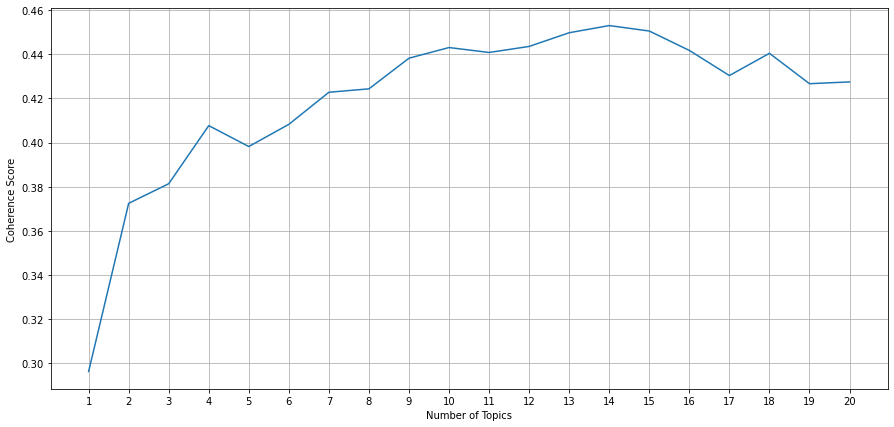

In [12]:
start_time = time.time() #Start count time
allwords_coherence = CalculateCoherenceRange(allwords_abstracts, allwords_bow, allwords_dictionary)
print('- Finish in', round((time.time() - start_time)/60), 'min(s)')

#Plot the coherence plot
plt.figure(figsize = (15, 7))
plt.plot(range(1, 21), allwords_coherence)
plt.xticks(range(1, 21))
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.grid()

## 1.2 LDA model with 7 topics

In [18]:
allwords_LDA_model = LdaModel(allwords_bow, num_topics = 7, id2word = allwords_dictionary, random_state = 111, passes = 30)

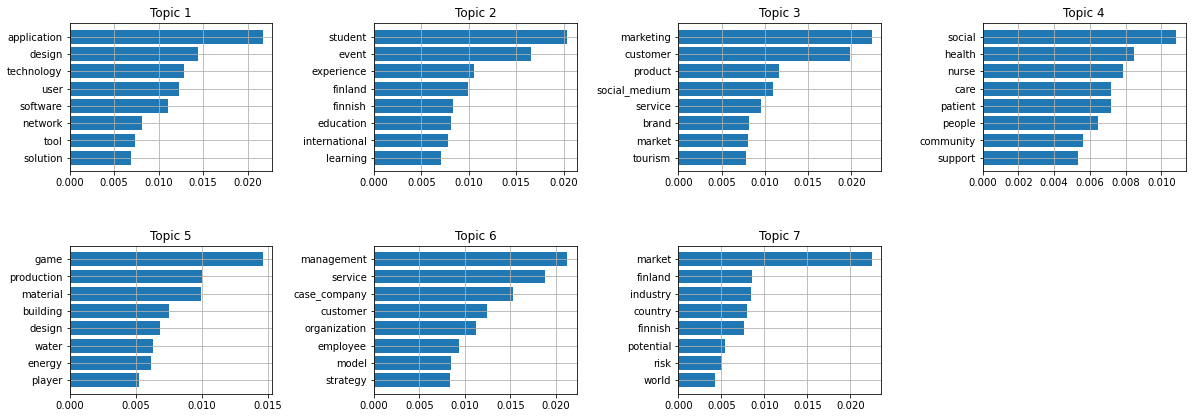

In [19]:
PlotKeywords(allwords_LDA_model, 7)

## 1.3 Plot topics

In [20]:
#Display the topics
allwords_display = gensimvis.prepare(allwords_LDA_model, allwords_bow, allwords_dictionary, sort_topics = False)
pyLDAvis.display(allwords_display)

**GUESSING TOPICS:**<br>
Topic 1 - Information Technology<br>
Topic 2 - Education<br>
Topic 3 - Marketing<br>
Topic 4 - Healthcare<br>
Topic 5 - Mixed topics \*<br>
Topic 6 - Management<br>
Topic 7 - Economy<br><br>
\* Seems not to be so clear<br>

## 1.4 Evaluate model

In [21]:
#Calculate Coherence Score
allwords_coherence = gensim.models.CoherenceModel(model = allwords_LDA_model, texts = allwords_abstracts, dictionary = allwords_dictionary, coherence = 'c_v')
print('Coherence Score:', round(allwords_coherence.get_coherence(), 3))

Coherence Score: 0.439


# 2. Only noun corpus

In [13]:
start_time = time.time() #Start count time

#Tokenization and delete punctuation, number, short words and stop words
nouns_pre_abstracts = []
count = defaultdict(int)
for abstract in eng_data['abstract_en']:
    noun = []
    for token in nltk.word_tokenize(abstract.lower()):
        if token.isalpha() and token not in eng_stopwords and len(token) > 3:
            for (word, pos) in nltk.pos_tag({lemmatizer.lemmatize(token)}):
                if pos[0] == 'N': #Take only noun
                    noun.append(word)
                    count[word] += 1 #Count word frequencies
    nouns_pre_abstracts.append(noun)

#Delete words that appear very few times
#nouns_abstracts = [[token for token in abstract if count[token] > 2] for abstract in nouns_pre_abstracts]
nouns_abstracts = nouns_pre_abstracts

end_time = time.time() #End count time
print('- Finish preprocessing data (nouns only) in', round((end_time - start_time)/60), 'min(s)')

- Finish preprocessing data (nouns only) in 19 min(s)


In [14]:
# Build the bigram
bigram = gensim.models.Phrases(nouns_abstracts, min_count = 10, threshold = 10)

In [15]:
for idx in range(len(nouns_abstracts)):
    nouns_abstracts[idx] = bigram[nouns_abstracts[idx]]

In [16]:
#Create dictionary for the given texts
nouns_dictionary = corpora.Dictionary(nouns_abstracts)
nouns_dictionary.filter_extremes(no_below = 10, no_above = 0.25) #Filter words that appear less than 10 documents and more than 25% of all documents
print(nouns_dictionary)

#Create the bag of words for all documents
nouns_bow = [nouns_dictionary.doc2bow(abstract) for abstract in nouns_abstracts]

Dictionary(4464 unique tokens: ['activity', 'analyse', 'area', 'book', 'clarify']...)


## 2.1 Choose the number of topics

. . . . . . . . . . . . . . . . . . . . 
- Finish in 253 min(s)


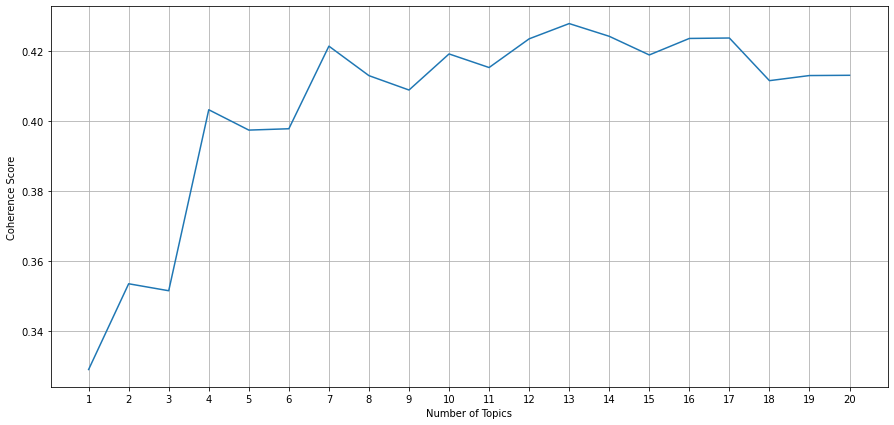

In [17]:
start_time = time.time() #Start count time
nouns_coherence = CalculateCoherenceRange(nouns_abstracts, nouns_bow, nouns_dictionary)
print('- Finish in', round((time.time() - start_time)/60), 'min(s)')

#Plot the coherence plot
plt.figure(figsize = (15, 7))
plt.plot(range(1, 21), nouns_coherence)
plt.xticks(range(1, 21))
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.grid()

## 2.2 LDA model with 6 topics

In [22]:
nouns_LDA_model = LdaModel(nouns_bow, num_topics = 7, id2word = nouns_dictionary, random_state = 111, passes = 50)

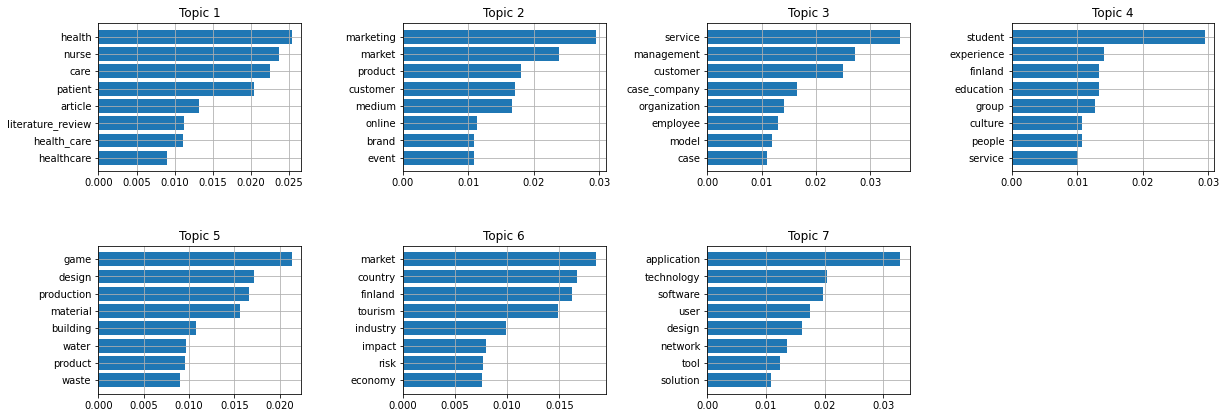

In [23]:
PlotKeywords(nouns_LDA_model, 7)

## 2.3 Plot topics

In [24]:
#Display the topics
nouns_display = gensimvis.prepare(nouns_LDA_model, nouns_bow, nouns_dictionary, sort_topics = False)
pyLDAvis.display(nouns_display)

**GUESSING TOPICS:**<br>
Topic 1 - Healthcare<br>
Topic 2 - Marketing<br>
Topic 3 - Management<br>
Topic 4 - Education<br>
Topic 5 - Mixed topics \*<br>
Topic 6 - Economy<br>
Topic 7 - Information Technology<br><br>
\* Seems not to be so clear<br>

## 2.4 Evaluate model

In [25]:
#Calculate Coherence Score
nouns_coherence = gensim.models.CoherenceModel(model = nouns_LDA_model, texts = nouns_abstracts, dictionary = nouns_dictionary, coherence = 'c_v')
print('Coherence Score:', round(nouns_coherence.get_coherence(), 3))

Coherence Score: 0.483
